<a href="https://colab.research.google.com/github/camigutie/DS4002-Project1/blob/main/SCRIPTS/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# !git clone https://github.com/camigutie/DS4002-Project1.git

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

In [8]:
df = pd.read_parquet('../DATA/email.parquet')

In [9]:
# Split data into features and target
X = df.drop(columns=['email_type'])
y = df['email_type']

In [10]:
# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [11]:
# Train the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [12]:
# Predict on the test set and calculate accuracy
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [13]:
# T-test to evaluate statistical significance of sentiment score between phishing and safe emails
phishing_scores = df[df['email_type'] == 1]['compound']
safe_scores = df[df['email_type'] == 0]['compound']
t_stat, p_value = ttest_ind(phishing_scores, safe_scores, equal_var=False)

In [ ]:
# Compile results
results = {
    'Model Accuracy': f"{accuracy:.2%}",
    'T-Test Statistic': float(t_stat),
    'P-Value': float(p_value),
    'Significant (p < 0.05)': bool(p_value < 0.05)
}

results

{'Model Accuracy': '96.38%',
 'T-Test Statistic': 9.595926964182647,
 'P-Value': 9.533187930925757e-22,
 'Significant (p < 0.05)': True}

In [45]:
feature_names = X.columns
coef = log_reg.coef_[0]

In [ ]:
feature_coef_dict = dict(zip(feature_names, coef))
sorted_features = sorted(feature_coef_dict.items(), key=lambda x: x[1], reverse=True)

In [58]:
# Top 30 phishing coefficients
top_30_positive = dict(sorted_features[:30])

# Bottom 30 safe coefficients
top_30_negative = dict(sorted_features[-30:])

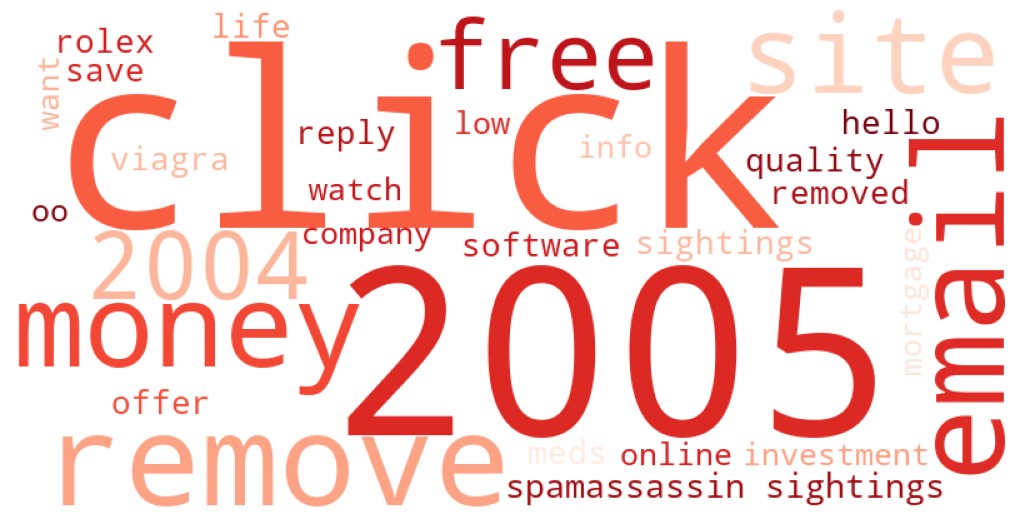

In [59]:
top_30_wordcloud_p = WordCloud(width=800, height=400, background_color="white", colormap='Reds').generate_from_frequencies(top_30_positive)
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(top_30_wordcloud_p)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../OUTPUT/reg_safe_wordcloud.png')
plt.show()

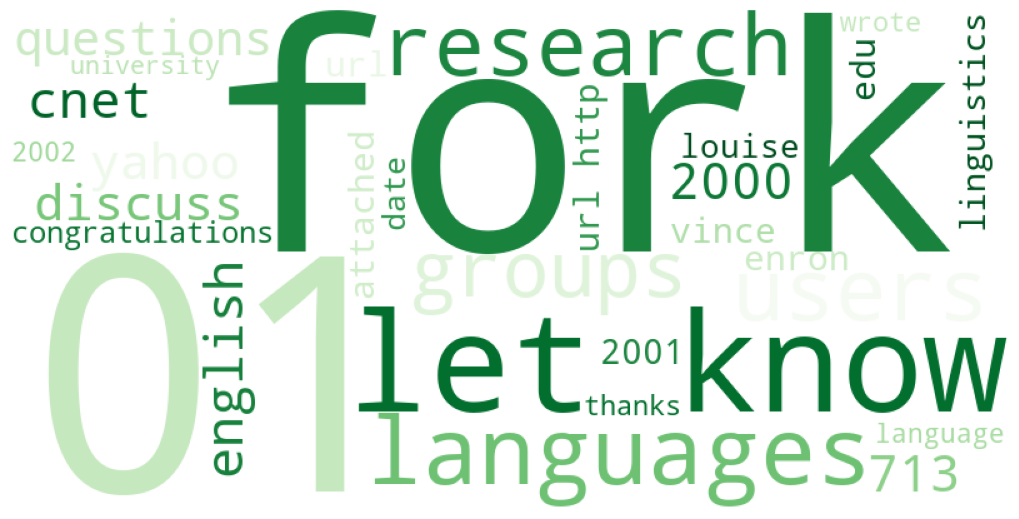

In [60]:
top_30_wordcloud_n = WordCloud(width=800, height=400, background_color="white", colormap='Greens').generate_from_frequencies(top_30_negative)
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(top_30_wordcloud_n)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('../OUTPUT/reg_phishing_wordcloud.png')
plt.show()

In [21]:
# Extract regression coefficients for sentiment scores
sentiment_coefs = {}
for i in range(4):
    sentiment_coefs[feature_names[i]] = float(coef[i])

In [22]:
sentiment_coefs

{'neg': -0.5117466676349279,
 'neu': -1.4870479845518718,
 'pos': 1.954962401533066,
 'compound': -0.16228207733618025}

In [62]:
features = list(sentiment_coefs.keys()) + [feature[0] for feature in sorted_features[:5]]
magnitudes = list(sentiment_coefs.values()) + [feature[1] for feature in sorted_features[:5]]

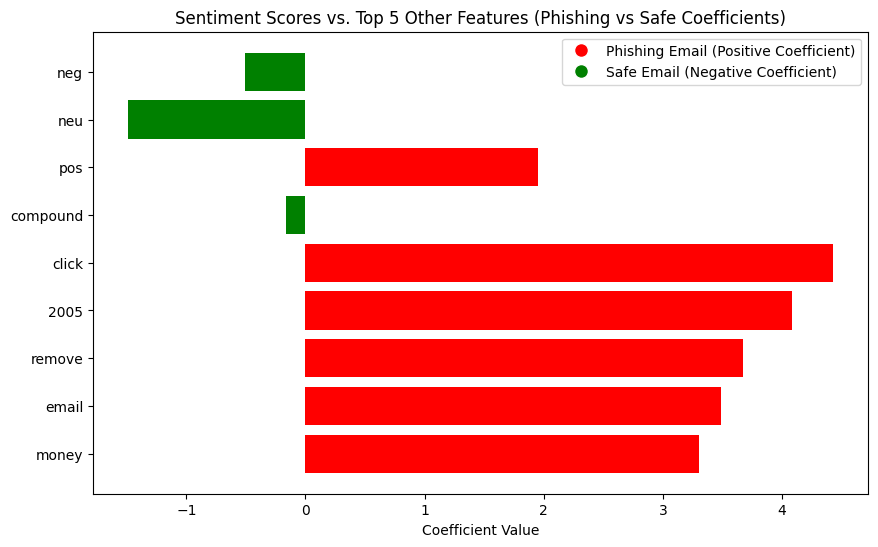

In [68]:
colors = ['red' if coef > 0 else 'green' for coef in magnitudes]  # Red for phishing, green for safe

# Plotting the bar chart with actual coefficients
plt.figure(figsize=(10, 6))
bars = plt.barh(features, magnitudes, color=colors)

# Adding legend
red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Phishing Email (Positive Coefficient)')
green_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Safe Email (Negative Coefficient)')
plt.legend(handles=[red_patch, green_patch], loc='upper right')

plt.xlabel('Coefficient Value')
plt.title('Sentiment Scores vs. Top 5 Other Features (Phishing vs Safe Coefficients)')
plt.gca().invert_yaxis()  # To have the largest values at the top
plt.savefig('../DATA/top_features.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      2254
           1       0.95      0.96      0.95      1473

    accuracy                           0.96      3727
   macro avg       0.96      0.96      0.96      3727
weighted avg       0.96      0.96      0.96      3727



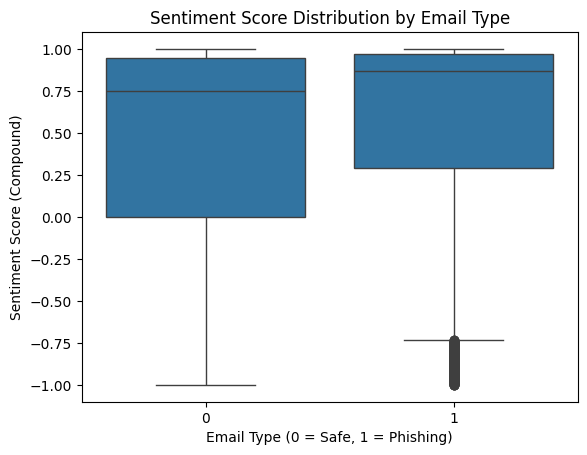

In [ ]:
sns.boxplot(x=df["email_type"], y=df["compound"])
plt.xlabel("Email Type (0 = Safe, 1 = Phishing)")
plt.ylabel("Sentiment Score (Compound)")
plt.title("Sentiment Score Distribution by Email Type")
plt.savefig("../OUTPUT/sentiment_distribution.png", bbox_inches='tight')
plt.show()

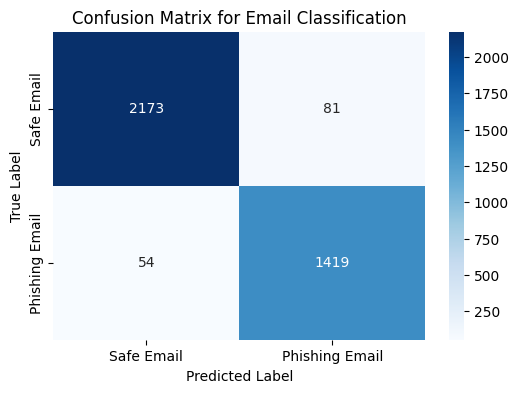

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
labels = ["Safe Email", "Phishing Email"]

# Create heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Titles and labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Email Classification")
plt.savefig("../OUTPUT/confusion_matrix.png", bbox_inches='tight')
plt.show()

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()